# Wages model

import warnings
warnings.filterwarnings("error")

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import pymc.sampling.jax as pmjax
import jax
import re
from io import StringIO 
import sys
import datetime

# Configurations
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

# Set random seed
RANDOM_SEED = 230810
rng = np.random.default_rng(RANDOM_SEED)

In [2]:
# Run this cell to set up ["CPU"] as the default backend for JAX. NOTE: Any change to the backend requires a restart of the kernel.
# CPU seems to be faster than GPU for this model
jax.config.update('jax_platform_name', 'cpu')
print(f"JAX default backend: {jax.default_backend()}")

JAX default backend: cpu


## a. Aux Functions

In [3]:
# Create a context manager that captures stdout output (Numpyro prints to stdout)
class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

In [4]:
def sampling_output(sampling_info, nchains, ndraws, ntunes):
    """ Function to organize the sampling info after the NUTS sampler has run."""
    sampling_metadata = {}
    for location, stage in enumerate(["Compilation", "Sampling", "Transformation"]):
        stage_duration = re.search(fr'{stage} time =\s+(\d+:\d+:\d+\.\d+)', sampling_info[(location * 2) + 1]).group(1)
        sampling_metadata[f"{stage}_time"] = stage_duration
        if stage == "Sampling":
            sampling_time_seconds = pd.to_timedelta(stage_duration).total_seconds()
            sampling_metadata["AvgIt/s"] = round(((ndraws + ntunes) * nchains) / sampling_time_seconds, 2)

    return sampling_metadata

## 1. Prepare Data

In [5]:
# Import data
data = pd.read_csv("slid_wages_2011.csv")

In [6]:
# Filter out columns of interest
df = data[["industry","occup","ftpt","sex","self_emp","union","public_sector","multiple_jobs","salary"]]

# Convert to categorical
df = df.rename(columns={"industry":"ind", "occup": "occ"})
df["ptm"] = pd.factorize(df["ftpt"])[0]
df["gender"] = pd.factorize(df["sex"])[0]
df["self"] = pd.factorize(df["self_emp"])[0]
df["union"] = pd.factorize(df["union"])[0]
df["public_sector"] = pd.factorize(df["public_sector"])[0]
df["multiple_jobs"] = pd.factorize(df["multiple_jobs"])[0]

# Drop columns
df = df.drop(columns=["ftpt","sex","self_emp"])
df.head(3)

ind  \
0                         construction   
1  information, culture and recreation   
2                                trade   

                                                 occ  union  public_sector  \
0                                  middle management      0              0   
1                                       other trades      1              1   
2  wholesale, technical, insurance, real estate s...      0              0   

   multiple_jobs        salary  ptm  gender  self  
0              0  54352.891156    0       0     0  
1              0  41096.088435    1       0     0  
2              0  79540.816327    0       0     0

In [7]:
# Dataset description
df.describe()

union  public_sector  multiple_jobs         salary          ptm  \
count  4420.000000    4420.000000    4420.000000    4420.000000  4420.000000   
mean      0.360407       0.312443       0.111086   74584.046801     0.092308   
std       0.480173       0.463542       0.314274   47617.238237     0.289493   
min       0.000000       0.000000       0.000000    2386.224490     0.000000   
25%       0.000000       0.000000       0.000000   43747.448980     0.000000   
50%       0.000000       0.000000       0.000000   66284.013605     0.000000   
75%       1.000000       1.000000       0.000000   96111.819728     0.000000   
max       1.000000       1.000000       1.000000  649583.333333     1.000000   

            gender         self  
count  4420.000000  4420.000000  
mean      0.495249     0.039140  
std       0.500034     0.193951  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%       1.000000     0.000000  
max       1.000000     1.000000

In [8]:
df.reindex().to_csv("model_dataset.csv")

In [9]:
data_summary = {
    "ind": {
        "type": "parameter",
        "element": "intercept",
        "data": pd.factorize(df["ind"])[0],
        "cats": pd.factorize(df["ind"])[1],
        "dims": "ind",
        "level": 1
    },
    "occ": {
        "type": "parameter",
        "element": "intercept",
        "data": pd.factorize(df["occ"])[0],
        "cats": pd.factorize(df["occ"])[1],
        "dims": "occ",
        "level": 1
    },
    "ptm": {
        "type": "parameter",
        "element": "slope",
        "data": pd.factorize(df["ptm"])[0],
        "cats": pd.factorize(df["ptm"])[1],
        "dims": "ind",
        "level": 1
    },
    "salary": {
        "type": "target",
        "element": None,
        "data": df["salary"].values,
        "cats": None,
        "dims": "obs",
        "level": None
    }
}

# Create coordinates
COORDS = {
    "obs": np.arange(len(df)),
    "ind": dataset["ind"]["cats"],
    "occ": dataset["occ"]["cats"],
}

NameError: name 'dataset' is not defined

In [27]:
data_summary = create_data_summary(pd.read_csv("../model_workflow.csv"), df, 2)

In [28]:
{ v["dims"]: np.arange(len(df)) if v["type"] == "target" else v["dims"]: v["cats"] for k, v in data_summary.items()  }

SyntaxError: invalid syntax (607888385.py, line 1)

In [29]:
{ v["dims"]: (np.arange(len(df)) if v["type"] == "target" else v["cats"]) for k, v in data_summary.items()}

{'ind': Index(['construction', 'information, culture and recreation', 'trade',
        'transportation and warehousing', 'health care and social assistance',
        'accommodation and food services',
        'professional, scientific and technical services',
        'public administration', 'manufacturing',
        'finance, insurance, real estate and leasing', 'educational services',
        'other services', 'business, building and other support services',
        'forestry, fishing, mining, oil and gas', 'utilities', 'agriculture'],
       dtype='object'),
 'occ': Index(['middle management', 'other trades',
        'wholesale, technical, insurance, real estate sales specialists',
        'transport and equipment operators',
        'occupations in social science, government service and religion',
        'chefs and cooks, food and beverage service',
        'clerical and supervisor occupations', 'natural and applied sciences',
        'machine operators and assemblers in manufactur

In [15]:
def make_data(data_summary, model):
    with model:
        model_data = {}
        for variable, data in data_summary.items():
            if data["type"] == "parameter":
                model_data[f"{variable}"] = pm.Data(f"data_{variable}", data["data"], mutable=False)
    return model, model_data

def make_hyperpriors(variable, data, model):
    with model:
        if data["type"] == "parameter":
            mu = pm.Normal(f'mu_{variable}', mu=0, sigma=10)
            sigma = pm.Exponential(f'sigma_{variable}', lam=10)
    return model

def make_prior(variable, data, model, param="centered"):
    with model:
        if data["type"] == "parameter":
            # Get hyperpriors
            mu = [ var for var in model.free_RVs if f"mu_{variable}" in var.name ][0]
            sigma = [ var for var in model.free_RVs if f"sigma_{variable}" in var.name ][0]

            # Define if centered or non-centered parametization
            if param == "centered":
                pm.Normal(f"beta_{variable}", mu=mu, sigma=sigma, dims=data["dims"])
            elif param == "non-centered":
                offset = pm.Normal(f"offset_{variable}", mu=0, sigma=1, dims=data["dims"])
                pm.Deterministic(f"beta_{variable}", mu + sigma * offset)
    return model

def make_ev_level(variables, model, level, model_data=None):
    mu = 0
    with model:
        for variable, data in variables:
            if data["type"] == "parameter":
                # Set parameter
                parameter = [ var for var in model.unobserved_RVs if f"beta_{variable}" in var.name ][0]

                # Define if intercept or slope
                if data["element"] == "intercept":
                    beta = 1
                elif data["element"] == "slope":
                    beta = model_data[f"{variable}"]
                    
                # Define define dimensions and parameter contribution to expected value
                if data["dims"] == None:
                    mu += parameter * beta
                else:
                    mu += parameter[model_data[f"{data['dims']}"]] * beta
        pm.Deterministic(f"ev_{level}", pm.math.exp(mu))
    return model

def make_levels(data_summary, model, model_data=None):
    with model:
        levels = { f"level_{v['level']}": [ (key, val) for key, val in data_summary.items() if val.get('level') == v['level']]
                      for v in data_summary.values() if v.get('level') is not None }
        for level, variables in levels.items():
            # Create hyperpriors and priors for the level
            for variable in variables:
                var_name, var_data = variable
                make_hyperpriors(var_name, var_data, model)
                make_prior(var_name, var_data, model)
            # Create expected value expression for the level
            make_ev_level(variables, model, level, model_data)
    return model

def make_likelihood(data_summary, model):
    with model:
        target = [ data["data"] for _, data in data_summary.items() if data["type"]=="target" ][0]
        shape = pm.Exponential("shape", lam=10)
        mu = [ var for var in model.unobserved_RVs if "ev" in var.name ][0]
        y = pm.Gamma("salary_hat", alpha=shape, beta=shape/mu,  observed=target)
    return model

def sample(model_name, model, nchains=4, ndraws=1000, ntune=1000, target_accept=0.95):
    # Save Model graph
    model_graph = pm.model_to_graphviz(model)
    model_graph.render(f"outputs/{model_name}/graph_{model_name}", format="svg")
    # Sampling
    with Capturing() as sampling_info: # This code captures the numpyro sampler stdout prints 
        with model:
            trace = pmjax.sample_numpyro_nuts(draws=ndraws, tune=ntune, target_accept=target_accept, chains=nchains, progressbar=False)
            trace.to_netcdf(f"outputs/{model_name}/trace_{model_name}.nc")
    # Save trace plot
    az.plot_trace(trace, combined=True, var_names=["~mu_","~sigma_","~ev_"], filter_vars="like")\
                    .ravel()[0].figure.savefig(f"outputs/{model_name}/traceplot_{model_name}.svg")
    # Save summary
    sampling_summary = pm.summary(trace)
    sampling_summary.to_csv(f"outputs/{model_name}/summary_{model_name}.csv")
    # Save sampling metadata
    sampling_metadata = sampling_output(sampling_info, nchains=nchains, ndraws=ndraws, ntunes=ntune)
    sampling_metadata["maxRhat"] = sampling_summary["r_hat"].max()
    
    return sampling_metadata

def run(id_run, model_name, data_summary, coords, sampling_record, nchains, ndraws, ntune, target_accept):
    start_time = datetime.datetime.now()
    # Setting up the model
    model = pm.Model(coords=coords)
    model, model_data = make_data(data_summary, model)
    model = make_levels(data_summary, model, model_data)
    model = make_likelihood(data_summary, model)

    # Sampling
    sampling = sample(model_name, model, nchains=nchains, ndraws=ndraws, ntune=ntune, target_accept=target_accept)
    sampling["start_time"] = start_time.strftime("%Y-%m-%d %H:%M")
    sampling["end_time"] = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
    sampling = { id_run: sampling }

    # Save sampling metadata info
    sampling_record = pd.concat([sampling_record, pd.DataFrame.from_dict(sampling, orient="index")])
    sampling_record.to_csv("sampling_record.csv")

    return sampling_record, run_summary

def create_data_summary(model_workflow, dataset, id_run):
    data_summary = {}
    for index, row in model_workflow.query(f"id_run == {id_run}").iterrows():
        data_summary[row["variable"]] = {
            "type": row["type"],
            "element": row["element"] if row["type"] == "parameter" else None,
            "data": pd.factorize(dataset[row["variable"]])[0] if row["type"] == "parameter" else dataset[row["variable"]].values,
            "cats": pd.factorize(dataset[row["variable"]])[1] if row["type"] == "parameter" else None,
            "dims": row["dims"],
            "level": row["level"] if row["type"] == "parameter" else None
        }
    return data_summary

def __main__():
    # Set sampling parameters
    nchains = 4
    ndraws = 1000
    ntune = 1000
    target_accept = 0.95

    # Create coordinates
    COORDS = {
        "obs": np.arange(len(df)),
        "ind": dataset["ind"]["cats"],
        "occ": dataset["occ"]["cats"],
    }

    # Load data and workflow
    model_workflow = pd.read_csv("model_workflow.csv") # Contains the model workflow
    dataset = pd.read_csv("slid_wages_2011.csv") # This is the dataset for model estimation

    # Get id_runs
    id_runs = model_workflow["id_run"].unique()

    # Create sampling record
    sampling_record = pd.DataFrame()

    # Run models
    for id_run in id_runs:
        # Create data summary
        data_summary = create_data_summary(model_workflow, dataset, id_run)
        
        # Run model
        sampling_record, run_summary = run(id_run=id_run,
                                            model_name=model_workflow.query(f"id_run == {id_run}")["model_name"][0],
                                            data_summary=data_summary,
                                            coords=COORDS,
                                            sampling_record=sampling_record,
                                            nchains=nchains,
                                            ndraws=ndraws,
                                            ntune=ntune,
                                            target_accept=target_accept)

        # Save sampling record and print summary
        sampling_record.to_csv("sampling_record.csv")
        print(f"Run {id_run} completed - Name: {run_summary['model_name']} - Start: {run_summary['start_time']} - End: {run_summary['end_time']} - Max Rhat: {run_summary['maxRhat']} - Avg It/s: {run_summary['AvgIt/s']}")
    

In [42]:
model_workflow = pd.read_csv("model_workflow.csv")
model_workflow

id_run          model_name  \
0       1      var_interc_ind   
1       1      var_interc_ind   
2       2  var_interc_ind_occ   
3       2  var_interc_ind_occ   
4       2  var_interc_ind_occ   
5       3   var_interc_slopes   
6       3   var_interc_slopes   
7       3   var_interc_slopes   

                                           model_def variable       type  \
0                     varying intercepts by industry      ind  parameter   
1                     varying intercepts by industry   salary     target   
2      varying intercepts by industry and occupation      ind  parameter   
3      varying intercepts by industry and occupation      occ  parameter   
4      varying intercepts by industry and occupation   salary     target   
5  varying intercepts by industry and slope (occu...      ind  parameter   
6  varying intercepts by industry and slope (occu...      occ  parameter   
7  varying intercepts by industry and slope (occu...   salary     target   

     element dims  level  
0  intercept  ind    1.0  
1        NaN  obs    NaN  
2  intercept  ind    1.0  
3  intercept  occ    1.0  
4        NaN  obs    NaN  
5  intercept  ind    1.0  
6      slope  occ    1.0  
7        NaN  obs    NaN

In [ ]:
    "ind": {
        "type": "parameter",
        "element": "intercept",
        "data": pd.factorize(df["ind"])[0],
        "cats": pd.factorize(df["ind"])[1],
        "dims": "ind",
        "level": 1
    },
    "salary": {
        "type": "target",
        "element": None,
        "data": df["salary"].values,
        "cats": None,
        "dims": "obs",
        "level": None
    }

{'Compilation_time': '0:00:02.399324', 'Sampling_time': '0:00:04.347196', 'AvgIt/s': 18.4, 'Transformation_time': '0:00:00.044891', 'maxRhat': 4.79, 'start_time': datetime.datetime(2023, 8, 23, 15, 5, 32, 42838), 'end_time': datetime.datetime(2023, 8, 23, 15, 5, 47, 203632)}
{'Compilation_time': '0:00:01.890335', 'Sampling_time': '0:00:04.673820', 'AvgIt/s': 17.12, 'Transformation_time': '0:00:00.091634', 'maxRhat': 4.79, 'start_time': datetime.datetime(2023, 8, 23, 15, 5, 47, 206122), 'end_time': datetime.datetime(2023, 8, 23, 15, 6, 2, 245283)}


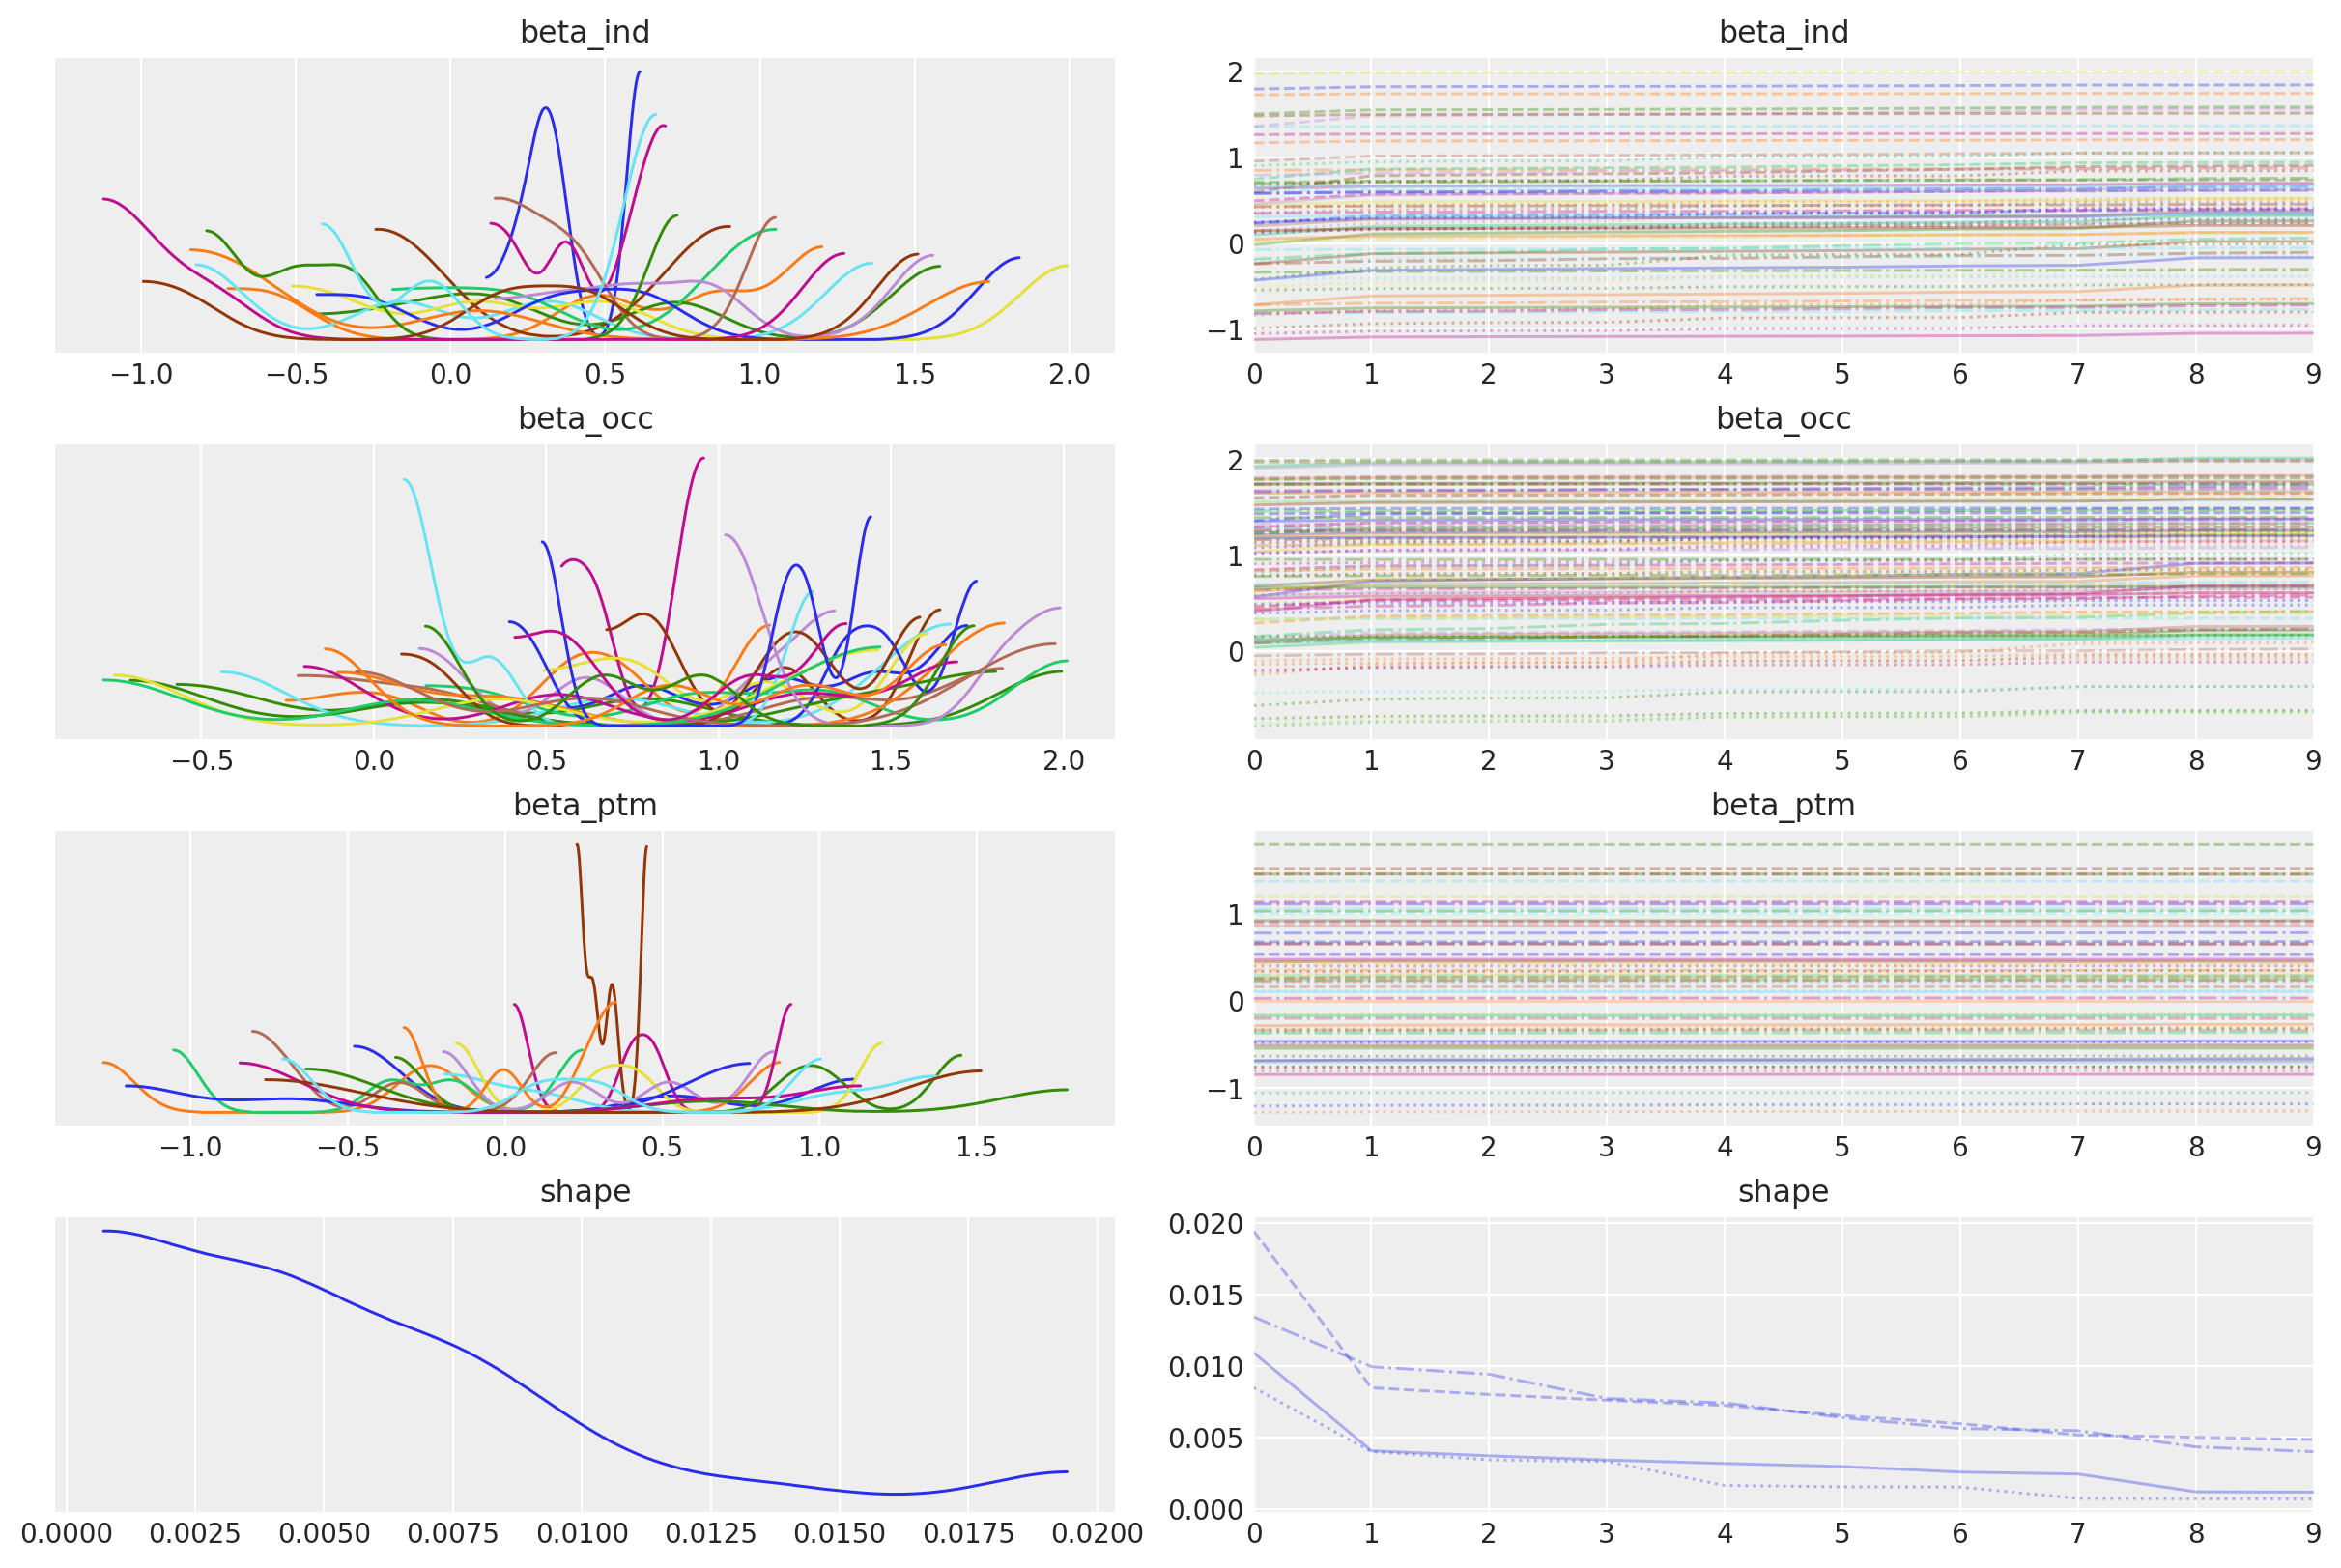

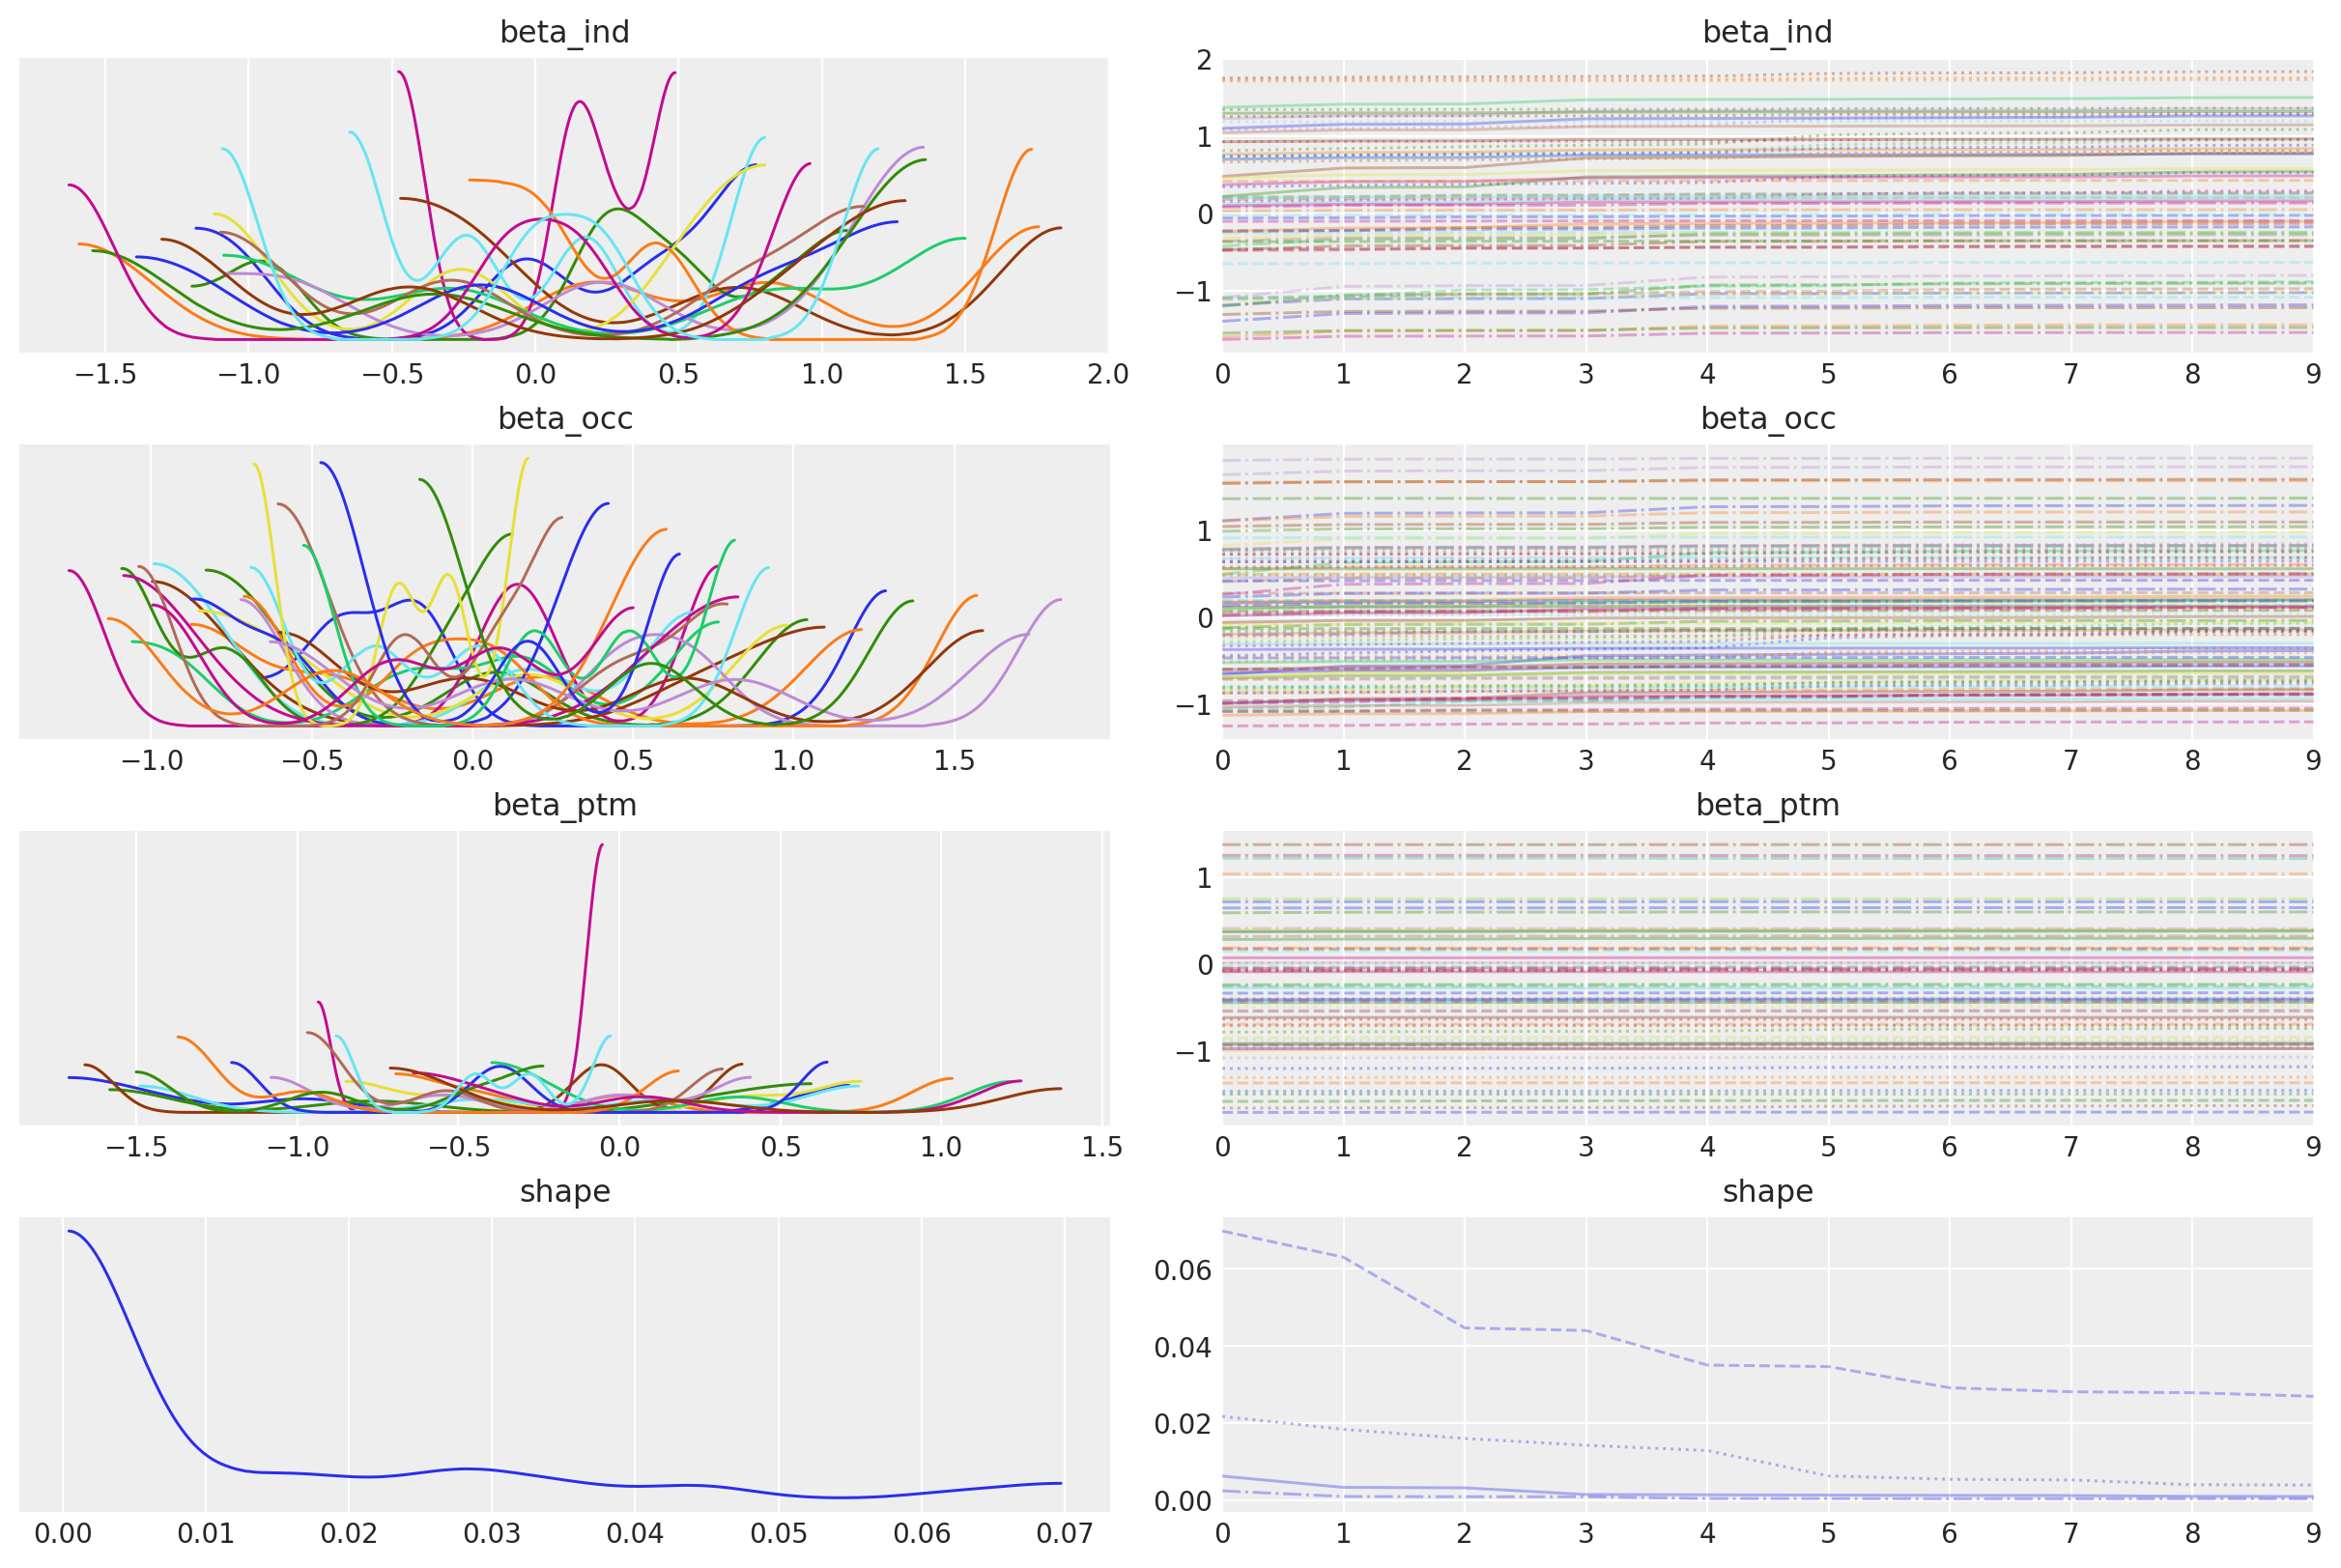

In [40]:
a = run("test1", dataset, COORDS, pd.DataFrame())
b = run("test2", dataset, COORDS, a)

In [28]:
%debug

> /home/avena/miniconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/compilerop.py(86)ast_parse()
     84         Arguments are exactly the same as ast.parse (in the standard library),
     85         and are passed to the built-in compile function."""
---> 86         return compile(source, filename, symbol, self.flags | PyCF_ONLY_AST, 1)
     87 
     88     def reset_compiler_flags(self):

*** Oldest frame
*** Newest frame
*** Newest frame


In [32]:
with model:
    trace = pmjax.sample_numpyro_nuts()

Compiling...
Compilation time =  0:00:02.137375
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:04:35.737875
Transforming variables...
Transformation time =  0:00:00.468079


In [34]:
pm.summary(trace, var_names=["~ev", "~offset"], filter_vars="like")

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_ind        4.805  6.928  -7.720   17.670      0.617    0.437     126.0   
mu_occ        6.355  6.936  -6.512   18.938      0.618    0.438     126.0   
mu_ptm       -0.782  0.056  -0.887   -0.677      0.006    0.004     106.0   
sigma_ind     0.238  0.045   0.161    0.325      0.006    0.004      53.0   
sigma_occ     0.228  0.034   0.167    0.288      0.009    0.007      14.0   
...             ...    ...     ...      ...        ...      ...       ...   
beta_ptm[11] -0.998  0.107  -1.190   -0.789      0.007    0.005     267.0   
beta_ptm[12] -0.882  0.135  -1.148   -0.643      0.008    0.006     296.0   
beta_ptm[13] -0.796  0.198  -1.193   -0.436      0.013    0.009     230.0   
beta_ptm[14] -0.768  0.149  -1.063   -0.495      0.011    0.008     188.0   
beta_ptm[15] -0.889  0.191  -1.227   -0.511      0.015    0.011     162.0   

              ess_tail  r_hat  
mu_ind           256.0   1.04  
mu_occ           251.0   1.04  
mu_ptm            69.0   1.03  
sigma_ind        133.0   1.04  
sigma_occ         64.0   1.22  
...                ...    ...  
beta_ptm[11]     432.0   1.02  
beta_ptm[12]     783.0   1.01  
beta_ptm[13]     385.0   1.01  
beta_ptm[14]     438.0   1.02  
beta_ptm[15]     256.0   1.03  

[63 rows x 9 columns]

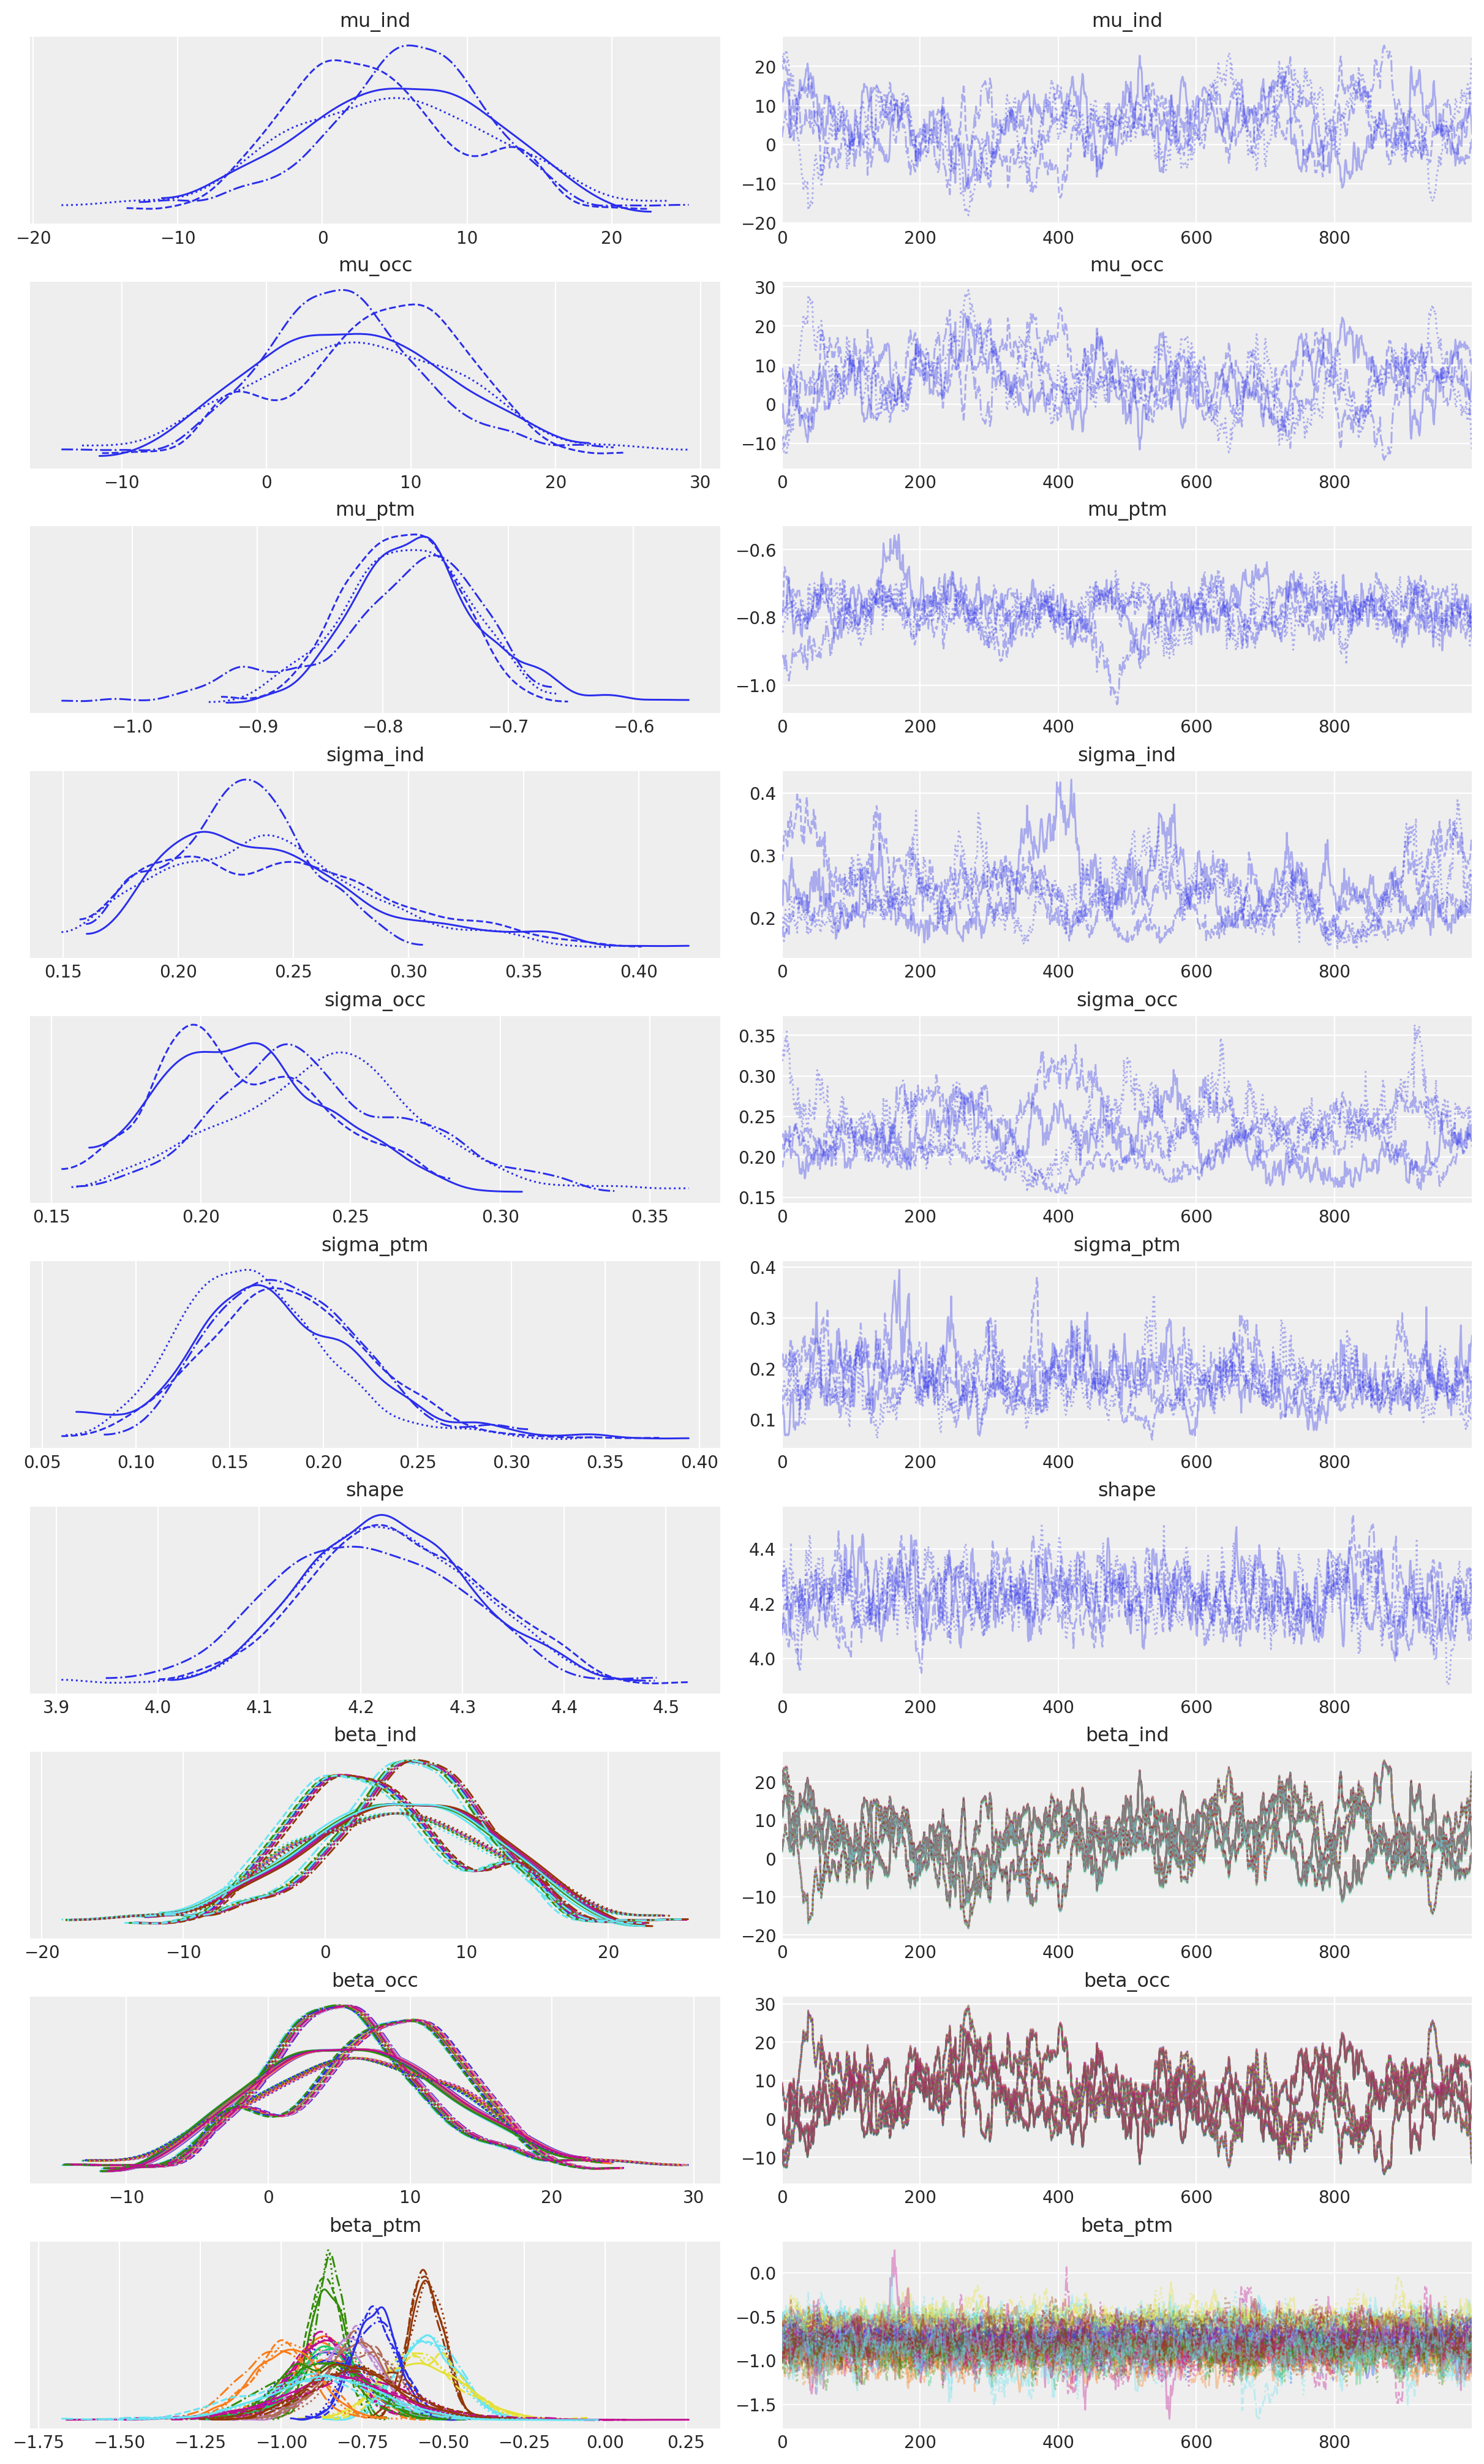

In [36]:
az.plot_trace(trace, var_names=["~ev","~offset"], filter_vars="like");

In [72]:
model.free_RVs

[mu_ind ~ Normal(0, 10),
 sigma_ind ~ Exponential(f()),
 mu_occ ~ Normal(0, 10),
 sigma_occ ~ Exponential(f()),
 beta_ind ~ Normal(mu_ind, sigma_ind),
 beta_occ ~ Normal(mu_occ, sigma_occ)]

In [18]:
pm.model_to_graphviz(model_obj)

In [19]:
model_h = hierarchical_normal('var', model_obj)

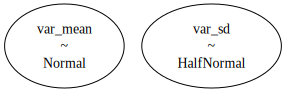

In [20]:
pm.model_to_graphviz(model_h)

In [ ]:
def make_priors(model):
    model = hierarchical_normal('a', model)
    model = hierarchical_normal('b', model)
    return model

def model_version_one():
    model = pm.Model()
    model = make_priors(model)
    with model:
        c = pm.Normal('c', model['a'] + model['b'], observed=data)
    return model

## 2. Model

In [14]:
# Create dimension vectors
intercepts = ["ind", "occ"]
parameters = intercepts + ["ptm","self","gender"]
dimensions = {}
for parameter in parameters:
    dimensions[parameter] = {}
    dimensions[parameter]["idx"], dimensions[parameter]["cats"] = pd.factorize(df[parameter])

salaries = df["salary"].values



In [15]:
baseModel = pm.Model(coords=COORDS)

In [16]:
pm.model_to_graphviz(baseModel)

In [17]:
with baseModel:
    # Data
    ind = pm.MutableData("ind", dimensions["ind"]["idx"])
    occ = pm.MutableData("occ", dimensions["occ"]["idx"])

    # Priors
    avg_salary_ind = pm.Normal("avg_salary", mu=0, sigma=10, dims="ind")
    avg_salary_occ = pm.Normal("avg_salary_occ", mu=0, sigma=10, dims="occ")

    # Expected value
    ev = pm.Deterministic('ev', avg_salary_ind[ind] + avg_salary_occ[occ])
    mu = pm.Deterministic('mu',pm.math.exp(ev))

    # Model error
    shape = pm.Exponential("shape", lam=1)

    # Likelihood
    salary = pm.Gamma("salary", alpha=shape, beta=shape/mu, observed=salaries)   

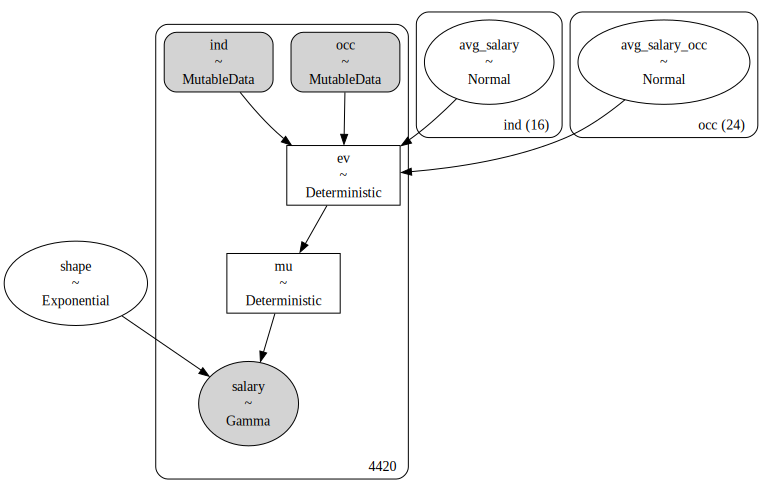

In [18]:
pm.model_to_graphviz(baseModel)

In [19]:
with baseModel:
    # # Data
    # ptm = pm.MutableData("ba", dimensions["ptm"]["idx"])

    # Priors
    avg_salary_ptm = pm.Normal("avg_salary_ptm", mu=0, sigma=10, dims="ind")

    # # Expected value
    # ev += avg_salary_ptm[ind]

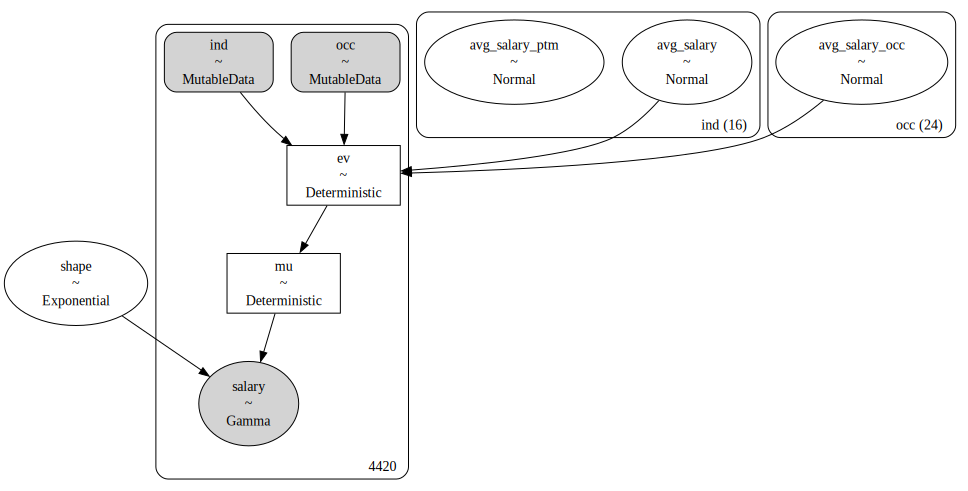

In [20]:
pm.model_to_graphviz(baseModel)

In [26]:
baseModel.register_rv('ev_f', pm.Deterministic('ev_2', avg_salary_ind[ind] + avg_salary_occ[occ] + avg_salary_ptm[ind], model=baseModel))

AttributeError: 'TensorVariable' object has no attribute 'endswith'

In [76]:
def base_model(model_name, COORDS):
    with pm.Model(coords=COORDS) as model_name:
        
    return model_name

In [77]:
a = base_model("bla", COORDS)

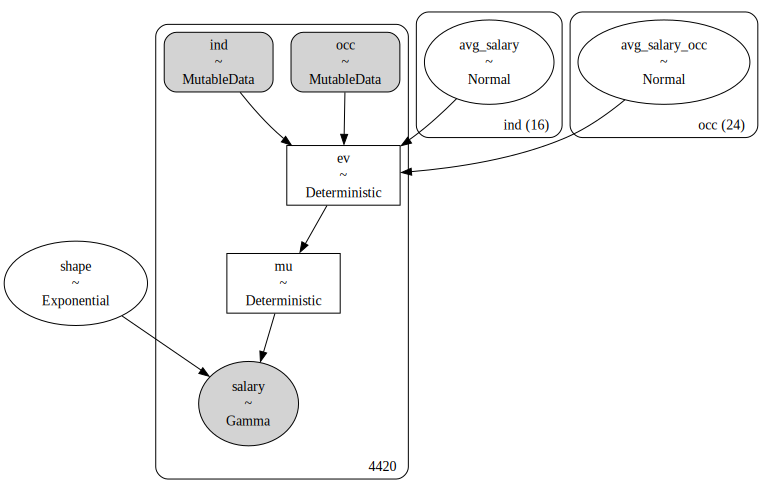

In [78]:
pm.model_to_graphviz(a)

In [79]:
with a:
    # Data
    ptm = pm.MutableData("ba", dimensions["ptm"]["idx"])

    # Priors
    avg_salary_ptm = pm.Normal("avg_salary_ptm", mu=0, sigma=10, dims="ind")

    # Expected value
    a.ev += avg_salary_ptm[a.ind]
    a.mu = pm.math.exp(a.ev)

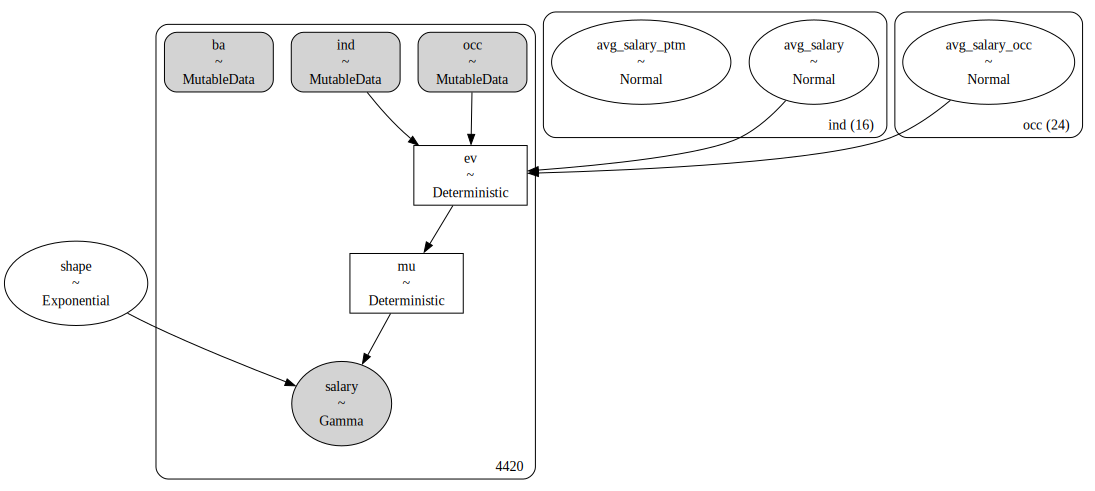

In [80]:
pm.model_to_graphviz(a)

In [61]:
vars = []
for id_var, variable in enumerate(["ptm","self","gender"]):
    vars.append(variable)
    with pm.Model(coords=COORDS) as model:
        # Parameter definition
        parameter_definition = { 
            f"{variable}": {
                "data": pm.MutableData(f"data_{variable}", dimensions[variable]["idx"]),
                "prior": pm.Normal(f"beta_{variable}", mu=0, sigma=10, dims="ind")
                }
            for variable in vars }

        # Data
        ind = pm.MutableData("ind", dimensions["ind"]["idx"])
        occ = pm.MutableData("occ", dimensions["occ"]["idx"])

        # Priors
        avg_salary_ind = pm.Normal("avg_salary", mu=0, sigma=10, dims="ind")
        avg_salary_occ = pm.Normal("avg_salary_occ", mu=0, sigma=10, dims="occ")

        # Expected value
        mu = avg_salary_ind[ind] + avg_salary_occ[occ]
        for parameter in parameter_definition.keys():
            mu += parameter_definition[parameter]["prior"][ind] * parameter_definition[parameter]["data"]

        mu = pm.math.exp(mu)

        # Model error
        shape = pm.Exponential("sigma", 1)

        # Likelihood
        salary = pm.Gamma("salary", alpha=shape, beta=shape/mu, observed=salaries)

        # Sample
        with Capturing() as sampling_info:
            trace = pmjax.sample_numpyro_nuts(10, tune=10, target_accept=0.95, progressbar=False)

        # Save trace
        trace.to_netcdf(f"trace_{'_'.join(vars)}.nc")

        # Save sampling metadata
        sampling_metadata = sampling_output(sampling_info, 10, 10, 10)
        
    
    
    # print(f"Model for {variable} created. {parameter_definition.keys()}")
    # print(pm.summary(trace))#.to_csv(f"summary_{variable}.csv")
    # gv = pm.model_to_graphviz(model)
    # gv.format = 'png'
    # gv.render(filename=f'model_graph_{id_var}')

In [62]:
sampling_info

['Compiling...',
 'Compilation time =  0:00:01.620980',
 'Sampling...',
 'Sampling time =  0:00:03.757347',
 'Transforming variables...',
 'Transformation time =  0:00:00.006690']

In [58]:


data = [
    'Compiling...',
    'Compilation time =  0:00:01.685618',
    'Sampling...',
    'Sampling time =  0:00:03.826616',
    'Transforming variables...',
    'Transformation time =  0:00:00.009453'
]

pattern = r'Compilation time =\s+(\d)+:\d+:(\d)+\.(\d+)'

compilation_times = []

for line in data:
    match = re.search(pattern, line)
    if match:
        compilation_times.append(match.group(3))

print(compilation_times)

['685618']


'0:00:03.826616'

In [18]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

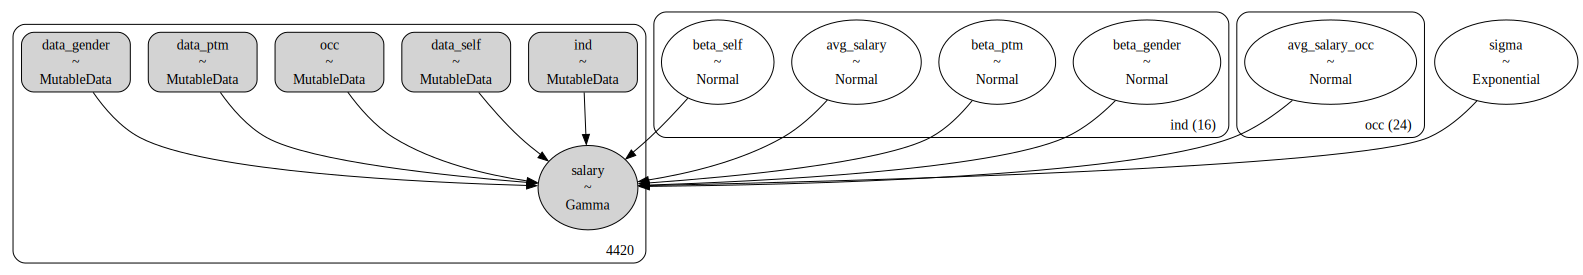

In [8]:
pm.model_to_graphviz(model)

In [10]:
pm.summary(trace, var_names=["beta_"], filter_vars="like")

mean      sd  hdi_3%  \
beta_ptm[construction]                             -0.686   0.175  -1.027   
beta_ptm[information, culture and recreation]      -0.849   0.124  -1.086   
beta_ptm[trade]                                    -0.770   0.053  -0.869   
beta_ptm[transportation and warehousing]           -0.769   0.107  -0.977   
beta_ptm[health care and social assistance]        -0.513   0.054  -0.609   
beta_ptm[accommodation and food services]          -0.481   0.095  -0.658   
beta_ptm[professional, scientific and technical... -0.175   0.183  -0.493   
beta_ptm[public administration]                    -0.849   0.128  -1.081   
beta_ptm[manufacturing]                            -0.650   0.121  -0.881   
beta_ptm[finance, insurance, real estate and le... -0.606   0.135  -0.858   
beta_ptm[educational services]                     -0.686   0.071  -0.817   
beta_ptm[other services]                           -1.201   0.131  -1.425   
beta_ptm[business, building and other support s... -0.958   0.183  -1.290   
beta_ptm[forestry, fishing, mining, oil and gas]    0.031  10.093 -18.917   
beta_ptm[utilities]                                -0.543   0.299  -1.075   
beta_ptm[agriculture]                              -1.816   0.514  -2.717   
beta_self[construction]                            -0.458   0.167  -0.788   
beta_self[information, culture and recreation]     -0.099   0.135  -0.346   
beta_self[trade]                                   -0.080   0.104  -0.262   
beta_self[transportation and warehousing]          -0.199   0.150  -0.470   
beta_self[health care and social assistance]       -0.071   0.110  -0.277   
beta_self[accommodation and food services]         -0.042   0.248  -0.493   
beta_self[professional, scientific and technica... -0.068   0.159  -0.371   
beta_self[public administration]                   -0.053   0.153  -0.339   
beta_self[manufacturing]                            0.032   0.134  -0.217   
beta_self[finance, insurance, real estate and l... -0.261   0.149  -0.548   
beta_self[educational services]                     0.078   0.093  -0.092   
beta_self[other services]                           0.559   0.235   0.104   
beta_self[business, building and other support ...  0.209   0.353  -0.446   
beta_self[forestry, fishing, mining, oil and gas]  -0.302   0.195  -0.644   
beta_self[utilities]                               -0.137   0.351  -0.798   
beta_self[agriculture]                             -1.114   0.238  -1.554   
beta_gender[construction]                          -0.442   0.107  -0.644   
beta_gender[information, culture and recreation]   -0.227   0.074  -0.373   
beta_gender[trade]                                 -0.276   0.040  -0.346   
beta_gender[transportation and warehousing]        -0.393   0.075  -0.537   
beta_gender[health care and social assistance]     -0.120   0.055  -0.221   
beta_gender[accommodation and food services]       -0.253   0.077  -0.394   
beta_gender[professional, scientific and techni... -0.444   0.068  -0.568   
beta_gender[public administration]                 -0.188   0.048  -0.279   
beta_gender[manufacturing]                         -0.362   0.045  -0.446   
beta_gender[finance, insurance, real estate and... -0.390   0.058  -0.504   
beta_gender[educational services]                  -0.160   0.047  -0.252   
beta_gender[other services]                        -0.237   0.084  -0.391   
beta_gender[business, building and other suppor... -0.152   0.100  -0.334   
beta_gender[forestry, fishing, mining, oil and ... -0.218   0.181  -0.551   
beta_gender[utilities]                             -0.426   0.120  -0.655   
beta_gender[agriculture]                           -0.316   0.157  -0.624   

                                                    hdi_97%  mcse_mean  \
beta_ptm[construction]                               -0.361      0.003   
beta_ptm[information, culture and recreation]        -0.622      0.002   
beta_ptm[trade]                                      -0.6

In [14]:
with model:
    # Sample
    trace = pmjax.sample_numpyro_nuts(draws=10000, tune=10000, target_accept=0.95, chains=10)

Compiling...


DeprecationWarning: jax.numpy.product is deprecated. Use jax.numpy.prod

In [7]:
with pm.Model(coords=COORDS) as model:
        # Data
        ind = pm.MutableData("ind", dimensions["ind"]["idx"])
        occ = pm.MutableData("occ", dimensions["occ"]["idx"])
        ptm = pm.MutableData("ptm", dimensions["ptm"]["idx"])

        # Priors
        avg_salary_ind = pm.Normal("avg_salary", mu=0, sigma=10, dims="ind")
        avg_salary_occ = pm.Normal("avg_salary_occ", mu=0, sigma=10, dims="occ")
        beta_ptm = pm.Normal("beta_ptm", mu=0, sigma=10, dims="ind")

        # Expected value
        mu = avg_salary_ind[ind] + avg_salary_occ[occ] + beta_ptm[ind] * ptm
        mu = pm.math.exp(mu)

        # Model error
        shape = pm.Exponential("sigma", 1)

        # Likelihood
        salary = pm.Gamma("salary", alpha=shape, beta=shape/mu, observed=salaries)

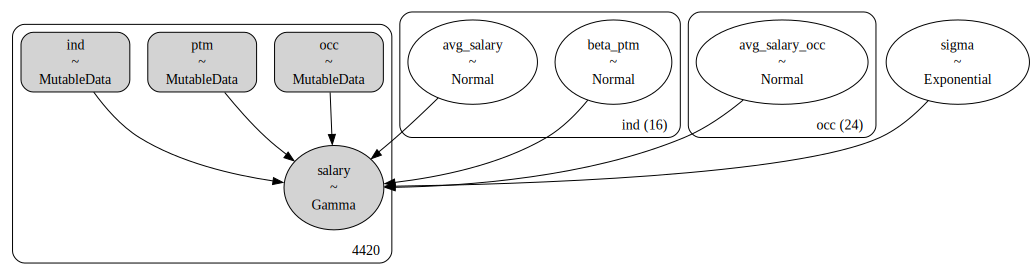

In [8]:
pm.model_to_graphviz(model)

In [9]:
with model:
    # Sample
    trace = pmjax.sample_numpyro_nuts(draws=10000, tune=10000, target_accept=0.95, chains=10)

Compiling...
Compilation time =  0:00:05.560267
Sampling...


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]